[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vovan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Оценка модели Logistic Regression ===

ROC-AUC по категориям:
Скорость: 0.9861
Качество выполнения: 0.9703
Качество сотрудников: 0.9203
Выполнение заявки: 0.9749
Вопрос решен: 0.9652

Средний ROC-AUC: 0.9634
Accuracy: 0.7389
Macro F1-score: 0.6738


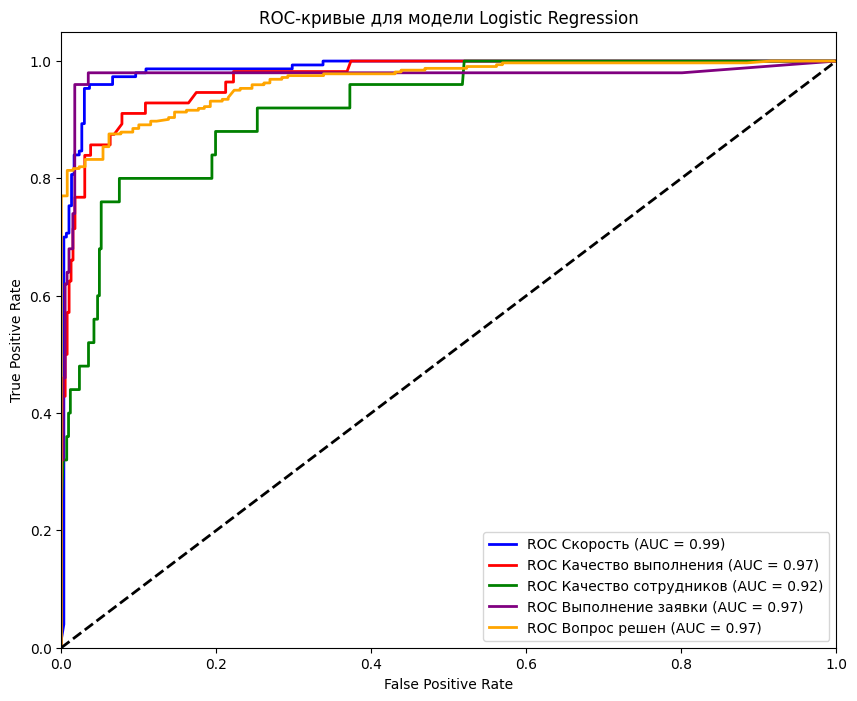


=== Оценка модели XGBoost ===

ROC-AUC по категориям:
Скорость: 0.9853
Качество выполнения: 0.9664
Качество сотрудников: 0.9389
Выполнение заявки: 0.9763
Вопрос решен: 0.9640

Средний ROC-AUC: 0.9662
Accuracy: 0.7832
Macro F1-score: 0.8328


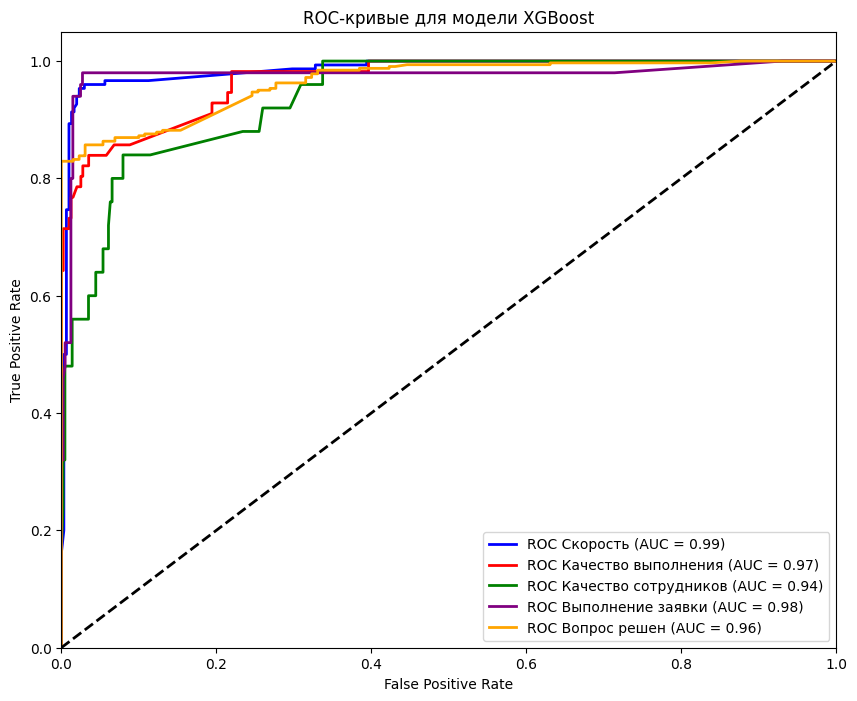


=== Пример классификации ===
Комментарий: Спасибо за быструю работу, мастер пришел сразу и все починил качественно

Logistic Regression:
Скорость: 0.7011
Качество выполнения: 0.3597
Качество сотрудников: 0.0773
Выполнение заявки: 0.0565
Вопрос решен: 0.8655

XGBoost:
Скорость: 0.8634
Качество выполнения: 0.7830
Качество сотрудников: 0.0257
Выполнение заявки: 0.0039
Вопрос решен: 0.9992

=== Проверка загрузки моделей ===
Модели успешно загружены!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from joblib import dump, load
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Загрузка данных
data = pd.read_csv('comments_with_binary_categories.csv')

# Выбор нужных колонок
categories = ['Скорость', 'Качество выполнения', 'Качество сотрудников', 'Выполнение заявки', 'Вопрос решен']
texts = data['comment']
labels = data[categories]

# Предварительная обработка текста
nltk.download('stopwords')
stop_words = stopwords.words('russian')
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

texts = texts.apply(preprocess_text)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Функция для обучения и оценки модели
def train_and_evaluate_model(model, model_name):
    print(f"\n=== Оценка модели {model_name} ===")
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', MultiOutputClassifier(model))
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Предсказание вероятностей
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Предсказание классов
    y_pred = pipeline.predict(X_test)
    
    # ROC-AUC для каждой категории
    roc_auc_scores = {}
    for i, category in enumerate(categories):
        roc_auc = roc_auc_score(y_test[category], y_pred_proba[i][:, 1])
        roc_auc_scores[category] = roc_auc
    
    # Средний ROC-AUC
    mean_roc_auc = np.mean(list(roc_auc_scores.values()))
    
    # Дополнительные метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("\nROC-AUC по категориям:")
    for category, score in roc_auc_scores.items():
        print(f"{category}: {score:.4f}")
    print(f"\nСредний ROC-AUC: {mean_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {f1:.4f}")
    
    # Визуализация ROC-кривых
    plot_roc_curves(y_test, y_pred_proba, model_name)
    
    return pipeline

# Функция для визуализации ROC-кривых
def plot_roc_curves(y_test, y_pred_proba, model_name):
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
    
    for i, color, category in zip(range(len(categories)), colors, categories):
        fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_proba[i][:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=color, lw=2,
                 label='ROC {0} (AUC = {1:0.2f})'
                 ''.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривые для модели {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# 1. Обучаем LogisticRegression
lr_model = train_and_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42), 
    "Logistic Regression"
)

# Сохраняем модель
dump(lr_model, 'logistic_regression_model.joblib')

# 2. Обучаем XGBoost
xgb_model = train_and_evaluate_model(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    "XGBoost"
)

# Сохраняем модель
dump(xgb_model, 'xgboost_model.joblib')

# Функция для классификации новых комментариев
def classify_comment(comment, model):
    processed_comment = preprocess_text(comment)
    probabilities = model.predict_proba([processed_comment])
    
    results = {}
    for i, category in enumerate(categories):
        results[category] = probabilities[i][0, 1]
    
    return results

# Пример использования
example_comment = "Спасибо за быструю работу, мастер пришел сразу и все починил качественно"

print("\n=== Пример классификации ===")
print(f"Комментарий: {example_comment}")

print("\nLogistic Regression:")
lr_result = classify_comment(example_comment, lr_model)
for category, prob in lr_result.items():
    print(f"{category}: {prob:.4f}")

print("\nXGBoost:")
xgb_result = classify_comment(example_comment, xgb_model)
for category, prob in xgb_result.items():
    print(f"{category}: {prob:.4f}")

# Загрузка моделей для проверки
print("\n=== Проверка загрузки моделей ===")
loaded_lr = load('logistic_regression_model.joblib')
loaded_xgb = load('xgboost_model.joblib')

print("Модели успешно загружены!")

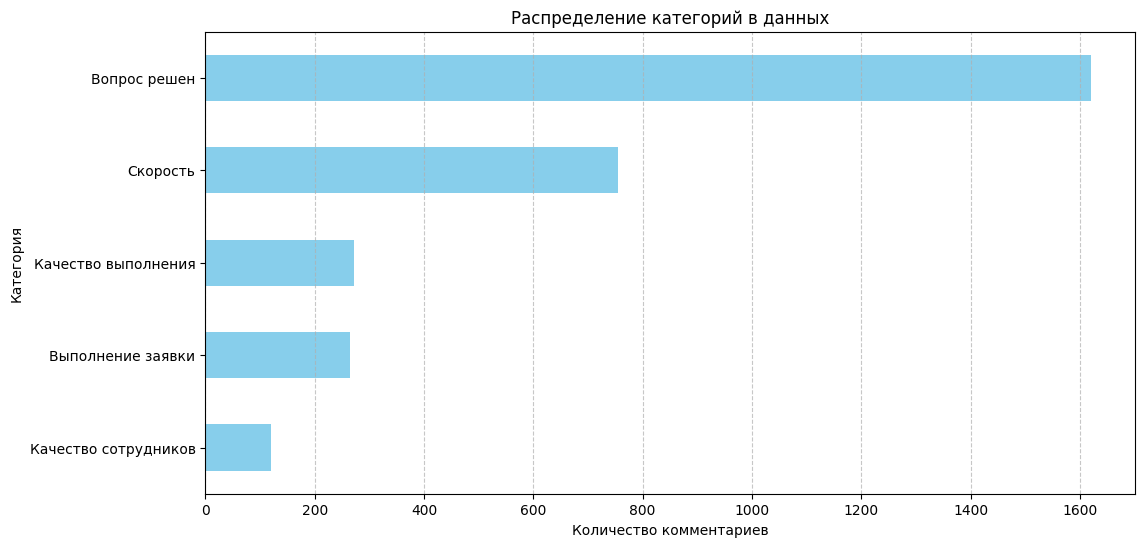

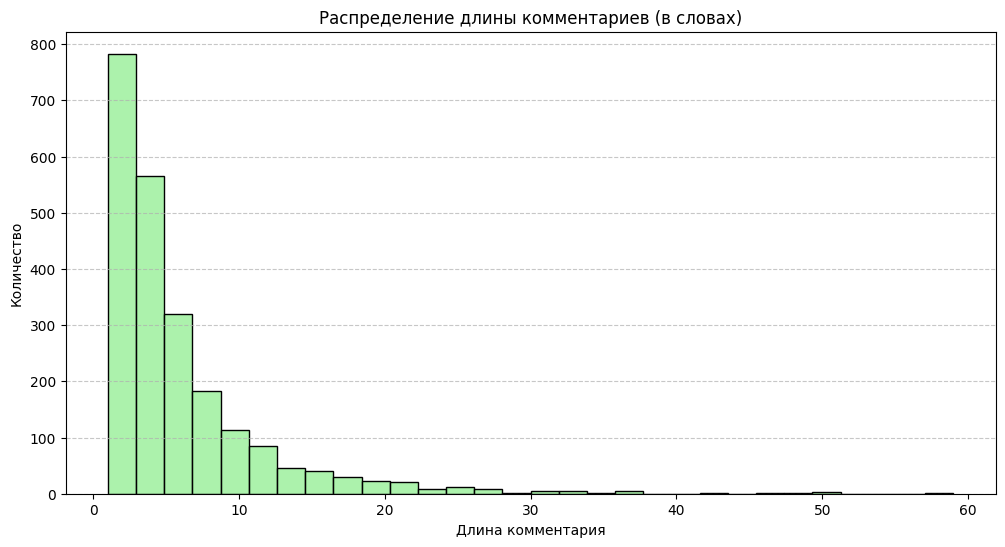

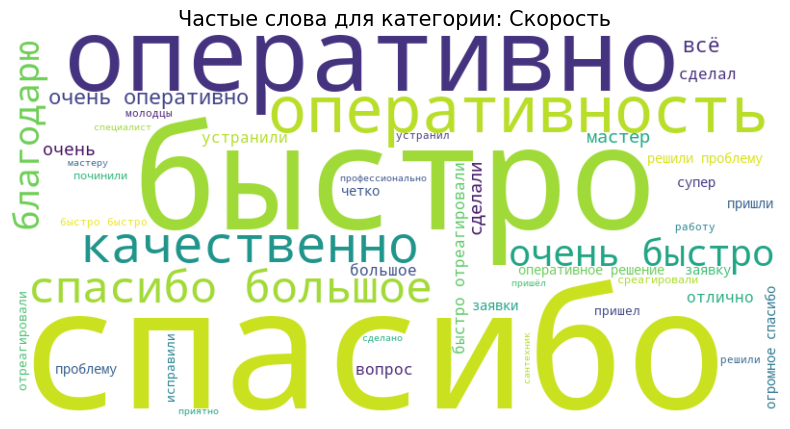

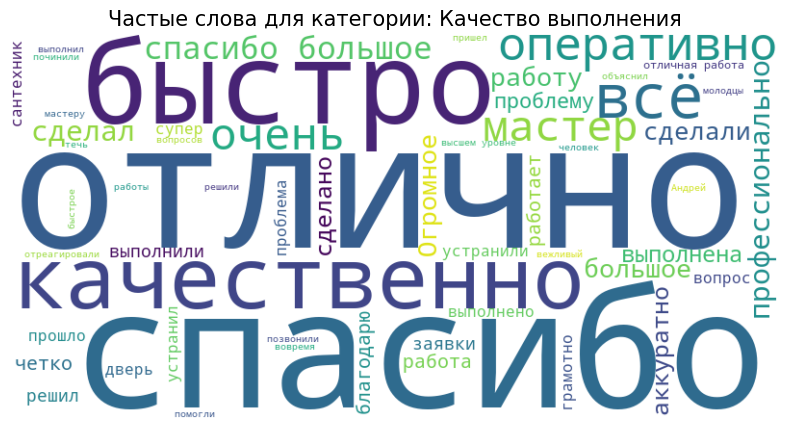

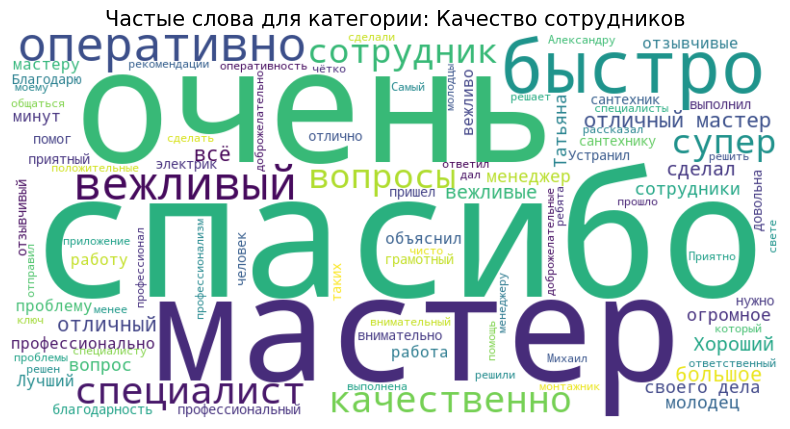

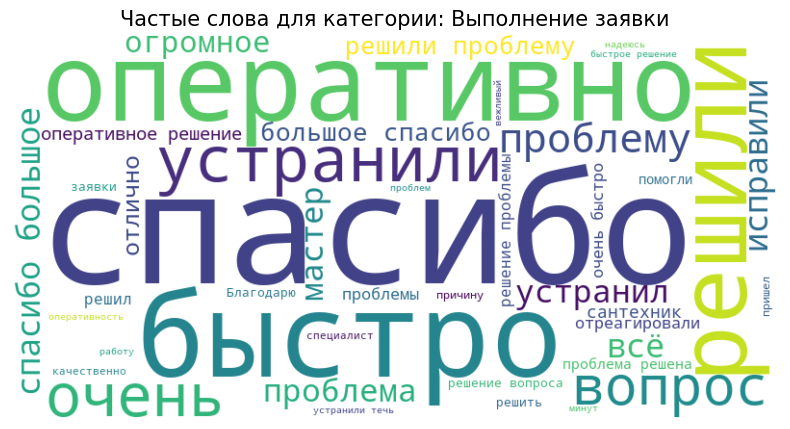

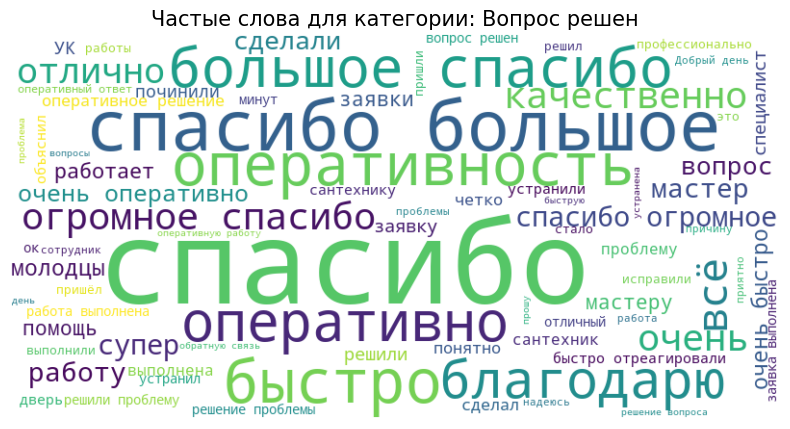

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vovan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Оценка модели Logistic Regression ===

ROC-AUC по категориям:
Скорость: 0.9861
Качество выполнения: 0.9703
Качество сотрудников: 0.9203
Выполнение заявки: 0.9749
Вопрос решен: 0.9652

Средний ROC-AUC: 0.9634
Accuracy: 0.7389
Macro F1-score: 0.6738


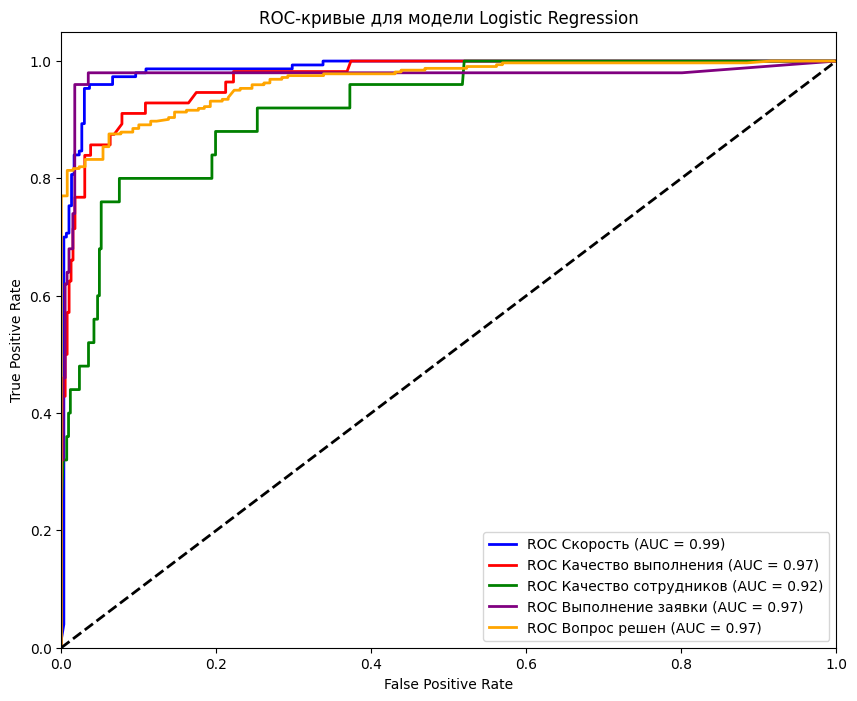


=== Оценка модели XGBoost ===

ROC-AUC по категориям:
Скорость: 0.9853
Качество выполнения: 0.9664
Качество сотрудников: 0.9389
Выполнение заявки: 0.9763
Вопрос решен: 0.9640

Средний ROC-AUC: 0.9662
Accuracy: 0.7832
Macro F1-score: 0.8328


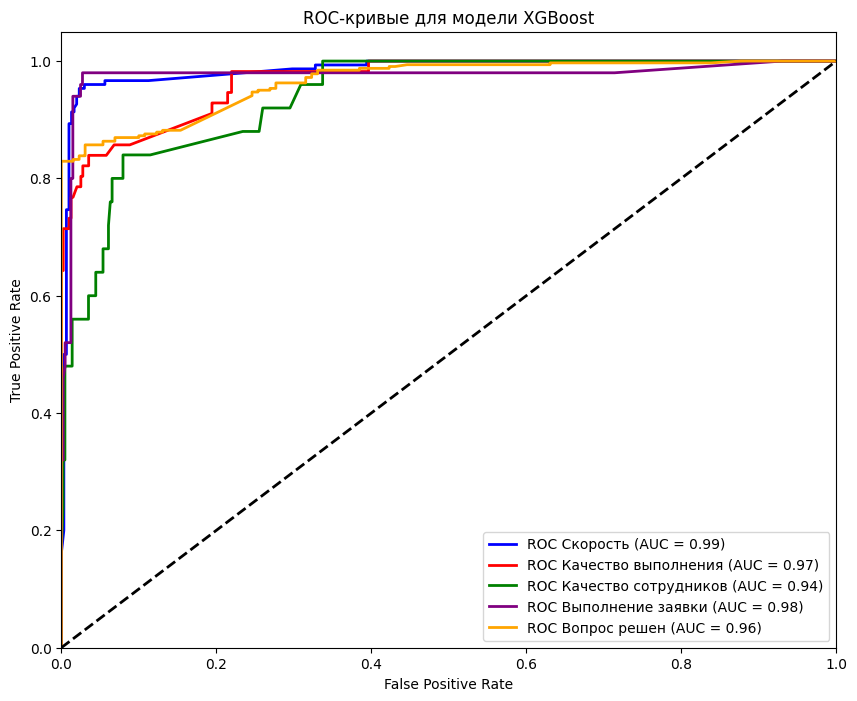

<Figure size 1200x600 with 0 Axes>

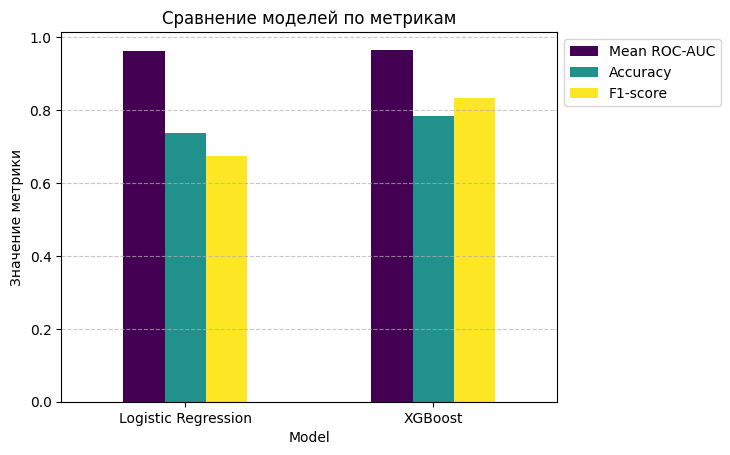


Сравнение моделей:
                 Model  Mean ROC-AUC  Accuracy  F1-score
0  Logistic Regression      0.963364  0.738938  0.673818
1              XGBoost      0.966180  0.783186  0.832842

=== Примеры классификации ===

Комментарий: Спасибо за быструю работу, мастер пришел сразу и все починил качественно

Logistic Regression:
Скорость: 0.7011
Качество выполнения: 0.3597
Качество сотрудников: 0.0773
Выполнение заявки: 0.0565
Вопрос решен: 0.8655

XGBoost:
Скорость: 0.8634
Качество выполнения: 0.7830
Качество сотрудников: 0.0257
Выполнение заявки: 0.0039
Вопрос решен: 0.9992
--------------------------------------------------

Комментарий: Очень долго ждали решения проблемы, но результат хороший

Logistic Regression:
Скорость: 0.2573
Качество выполнения: 0.0735
Качество сотрудников: 0.0767
Выполнение заявки: 0.7312
Вопрос решен: 0.4398

XGBoost:
Скорость: 0.0126
Качество выполнения: 0.0037
Качество сотрудников: 0.0447
Выполнение заявки: 0.9726
Вопрос решен: 0.3799
---------------------

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from joblib import dump, load
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

# Загрузка данных
data = pd.read_csv('comments_with_binary_categories.csv')

# Выбор нужных колонок
categories = ['Скорость', 'Качество выполнения', 'Качество сотрудников', 'Выполнение заявки', 'Вопрос решен']
texts = data['comment']
labels = data[categories]

# =============================================
# 1. Визуализация распределения категорий
# =============================================
plt.figure(figsize=(12, 6))
labels.sum().sort_values().plot(kind='barh', color='skyblue')
plt.title('Распределение категорий в данных')
plt.xlabel('Количество комментариев')
plt.ylabel('Категория')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# =============================================
# 2. Визуализация длины комментариев
# =============================================
text_lengths = texts.apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(text_lengths, bins=30, color='lightgreen')
plt.title('Распределение длины комментариев (в словах)')
plt.xlabel('Длина комментария')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# =============================================
# 3. Облако слов для каждой категории
# =============================================
def generate_wordclouds(texts, labels, categories):
    for category in categories:
        # Выбираем тексты для текущей категории
        category_texts = ' '.join(texts[labels[category] == 1].astype(str))
        
        # Генерируем облако слов
        wordcloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             stopwords=stopwords.words('russian'),
                             min_font_size=10).generate(category_texts)
        
        # Отображаем облако слов
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Частые слова для категории: {category}', fontsize=15)
        plt.axis("off")
        plt.show()

generate_wordclouds(texts, labels, categories)

# Предварительная обработка текста
nltk.download('stopwords')
stop_words = stopwords.words('russian')
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

texts = texts.apply(preprocess_text)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Функция для получения важных слов из модели
def get_top_words(model, feature_names, n_top_words=10):
    top_words = {}
    for i, category in enumerate(categories):
        if hasattr(model, 'coef_'):
            # Для линейных моделей (LogisticRegression)
            coef = model.coef_[i]
            top_indices = coef.argsort()[-n_top_words:][::-1]
            top_words[category] = [feature_names[idx] for idx in top_indices]
        else:
            # Для XGBoost
            importance = model.feature_importances_[i]
            top_indices = importance.argsort()[-n_top_words:][::-1]
            top_words[category] = [feature_names[idx] for idx in top_indices]
    return top_words

# Функция для обучения и оценки модели
def train_and_evaluate_model(model, model_name):
    print(f"\n=== Оценка модели {model_name} ===")
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', MultiOutputClassifier(model))
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Получаем названия признаков (слова)
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    
    # Предсказание вероятностей
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Предсказание классов
    y_pred = pipeline.predict(X_test)
    
    # ROC-AUC для каждой категории
    roc_auc_scores = {}
    for i, category in enumerate(categories):
        roc_auc = roc_auc_score(y_test[category], y_pred_proba[i][:, 1])
        roc_auc_scores[category] = roc_auc
    
    # Средний ROC-AUC
    mean_roc_auc = np.mean(list(roc_auc_scores.values()))
    
    # Дополнительные метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("\nROC-AUC по категориям:")
    for category, score in roc_auc_scores.items():
        print(f"{category}: {score:.4f}")
    print(f"\nСредний ROC-AUC: {mean_roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {f1:.4f}")
    
    # Визуализация ROC-кривых
    plot_roc_curves(y_test, y_pred_proba, model_name)
    
    # Визуализация важных слов
    if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        top_words = get_top_words(pipeline.named_steps['clf'].estimators_[0], feature_names)
        plot_top_words(top_words, model_name)
    
    return pipeline

# Функция для визуализации ROC-кривых
def plot_roc_curves(y_test, y_pred_proba, model_name):
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
    
    for i, color, category in zip(range(len(categories)), colors, categories):
        fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_proba[i][:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=color, lw=2,
                 label='ROC {0} (AUC = {1:0.2f})'
                 ''.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривые для модели {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Функция для визуализации важных слов
def plot_top_words(top_words, model_name):
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        plt.subplot(2, 3, i+1)
        words = top_words[category]
        values = range(len(words), 0, -1)
        
        plt.barh(words, values, color='skyblue')
        plt.title(f'Важные слова: {category}')
        plt.xlabel('Важность')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.suptitle(f'Важные слова для каждой категории ({model_name})', fontsize=15)
    plt.tight_layout()
    plt.show()

# =============================================
# 4. Сравнение моделей
# =============================================
# 1. Обучаем LogisticRegression
lr_model = train_and_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42), 
    "Logistic Regression"
)

# Сохраняем модель
dump(lr_model, 'logistic_regression_model.joblib')

# 2. Обучаем XGBoost
xgb_model = train_and_evaluate_model(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    "XGBoost"
)

# Сохраняем модель
dump(xgb_model, 'xgboost_model.joblib')

# =============================================
# 5. Сравнение метрик моделей
# =============================================
def compare_models(models):
    metrics = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Вычисляем метрики
        roc_auc_scores = []
        for i, category in enumerate(categories):
            roc_auc = roc_auc_score(y_test[category], y_pred_proba[i][:, 1])
            roc_auc_scores.append(roc_auc)
        
        mean_roc_auc = np.mean(roc_auc_scores)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        metrics.append({
            'Model': name,
            'Mean ROC-AUC': mean_roc_auc,
            'Accuracy': accuracy,
            'F1-score': f1
        })
    
    # Создаем DataFrame с метриками
    metrics_df = pd.DataFrame(metrics)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    metrics_df.set_index('Model').plot(kind='bar', rot=0, colormap='viridis')
    plt.title('Сравнение моделей по метрикам')
    plt.ylabel('Значение метрики')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return metrics_df

# Сравниваем модели
models = {
    'Logistic Regression': lr_model,
    'XGBoost': xgb_model
}
metrics_comparison = compare_models(models)
print("\nСравнение моделей:")
print(metrics_comparison)

# =============================================
# 6. Пример классификации
# =============================================
def classify_comment(comment, model):
    processed_comment = preprocess_text(comment)
    probabilities = model.predict_proba([processed_comment])
    
    results = {}
    for i, category in enumerate(categories):
        results[category] = probabilities[i][0, 1]
    
    return results

# Примеры комментариев для классификации
example_comments = [
    "Спасибо за быструю работу, мастер пришел сразу и все починил качественно",
    "Очень долго ждали решения проблемы, но результат хороший",
    "Сотрудник был вежлив, но качество работы оставляет желать лучшего",
    "Проблема решена, спасибо",
    "Все сделали быстро и качественно, молодцы!"
]

print("\n=== Примеры классификации ===")
for comment in example_comments:
    print(f"\nКомментарий: {comment}")
    
    print("\nLogistic Regression:")
    lr_result = classify_comment(comment, lr_model)
    for category, prob in lr_result.items():
        print(f"{category}: {prob:.4f}")
    
    print("\nXGBoost:")
    xgb_result = classify_comment(comment, xgb_model)
    for category, prob in xgb_result.items():
        print(f"{category}: {prob:.4f}")
    print("-"*50)

# Загрузка моделей для проверки
print("\n=== Проверка загрузки моделей ===")
loaded_lr = load('logistic_regression_model.joblib')
loaded_xgb = load('xgboost_model.joblib')

print("Модели успешно загружены!")